In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [30]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [31]:
base = ["Make", "Model", "Year", "Engine HP", "Engine Cylinders", "Transmission Type", "Vehicle Style", "highway MPG", "city mpg", "MSRP"]
df = df[base]
categorical = ["make", "model", "transmission_type", "vehicle_style"]
numerical = ["year", "engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]
df = df[base]
df.columns = df.columns.str.lower().str.replace(' ', '_')
for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ', '_')
df = df.fillna(0)
mean_price = df.msrp.mean()
print("mean_price", mean_price.round())
df["above_average"] = [1 if price > mean_price else 0 for price in df.msrp]
df.drop("msrp", axis=1, inplace=True)
df.head()

mean_price 40595.0


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0


In [32]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [33]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [34]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
is_avobe_average = (y_pred >= 0.5)
(y_val == is_avobe_average).mean()

0.931598825010491

### Q1

In [35]:
from sklearn.metrics import roc_auc_score

In [36]:
scores = []

for feature in numerical:
  score = roc_auc_score(y_train, df_train[feature])
  if score < 0.5:
    score = roc_auc_score(y_train, -df_train[feature])
  scores.append((feature, score))

scores.sort(key=lambda x: x[1], reverse=True)
scores


[('engine_hp', 0.9171031265539011),
 ('engine_cylinders', 0.766116490165669),
 ('year', 0.687551492804683),
 ('city_mpg', 0.6734244643245233),
 ('highway_mpg', 0.6330587871772013)]

### Q2

In [37]:
round(roc_auc_score(y_val, y_pred), 3)

0.977

### Q3

In [38]:
scores = []

thresholds = np.linspace(0, 0.99, 100)

for t in thresholds:
  actual_positive = (y_val == 1)
  actual_negative = (y_val == 0)
  
  predict_positive = (y_pred >= t)
  predict_negative = (y_pred < t)

  tp = (predict_positive & actual_positive).sum()
  tn = (predict_negative & actual_negative).sum()

  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()
  
  scores.append((t, tp, fp, fn, tn))

In [39]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores[::10]

,threshold,tp,fp,fn,tn,recall,precision
0,0.0,654,1729,0,0,0.274444,1.000000
10,0.1,643,345,11,1384,0.650810,0.983180
20,0.2,622,218,32,1511,0.740476,0.951070
30,0.3,606,159,48,1570,0.792157,0.926606
40,0.4,588,109,66,1620,0.843615,0.899083
50,0.5,567,76,87,1653,0.881804,0.866972
60,0.6,522,49,132,1680,0.914186,0.798165
70,0.7,490,36,164,1693,0.931559,0.749235
80,0.8,440,17,214,1712,0.962801,0.672783
90,0.9,347,4,307,1725,0.988604,0.530581


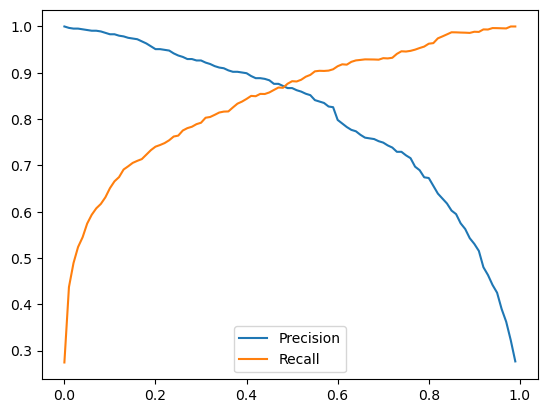

In [40]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

In [41]:
df_scores.loc[abs(df_scores.recall - df_scores.precision) < 0.005]

,threshold,tp,fp,fn,tn,recall,precision
48,0.48,570,87,84,1642,0.86758,0.87156


### Q4

In [42]:
df_scores['f1'] = (2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))
df_scores.sort_values(by=['f1'])[-1:]

,threshold,tp,fp,fn,tn,recall,precision,f1
50,0.5,567,76,87,1653,0.881804,0.866972,0.874325


### Q5

In [43]:
from sklearn.model_selection import KFold

In [44]:
def train(df_train, y_train, C=1.0):
  dicts = df_train[categorical + numerical].to_dict(orient='records')

  dv = DictVectorizer(sparse=False)
  X_train = dv.fit_transform(dicts)

  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
  model.fit(X_train, y_train)
  
  return dv, model

In [45]:
def predict(df, dv, model):
  dicts = df[categorical + numerical].to_dict(orient='records')

  X = dv.transform(dicts)
  y_pred = model.predict_proba(X)[:, 1]

  return y_pred

In [50]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = df_train.above_average.values
  y_val = df_val.above_average.values

  dv, model = train(df_train, y_train, C=1.0)
  y_pred = predict(df_val, dv, model)

  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)

  print('AUC %.3f +- %.3f' % (np.mean(scores), np.std(scores)))



AUC 0.978 +- 0.000
AUC 0.978 +- 0.000
AUC 0.980 +- 0.003
AUC 0.980 +- 0.003
AUC 0.979 +- 0.003


### Q6

In [47]:

for C in [0.01, 0.1, 0.5, 10]:
  kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

  scores = []

  for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

  print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.001
C=0.5 0.979 +- 0.002
C=10 0.984 +- 0.003
